# Regularization of CNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from IPython.display import clear_output
from early_stopping_pytorch.pytorchtools import EarlyStopping

%matplotlib inline
torch.manual_seed(17)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

ModuleNotFoundError: No module named 'early_stopping_pytorch'

In [3]:
plt.rcParams['text.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

Files already downloaded and verified


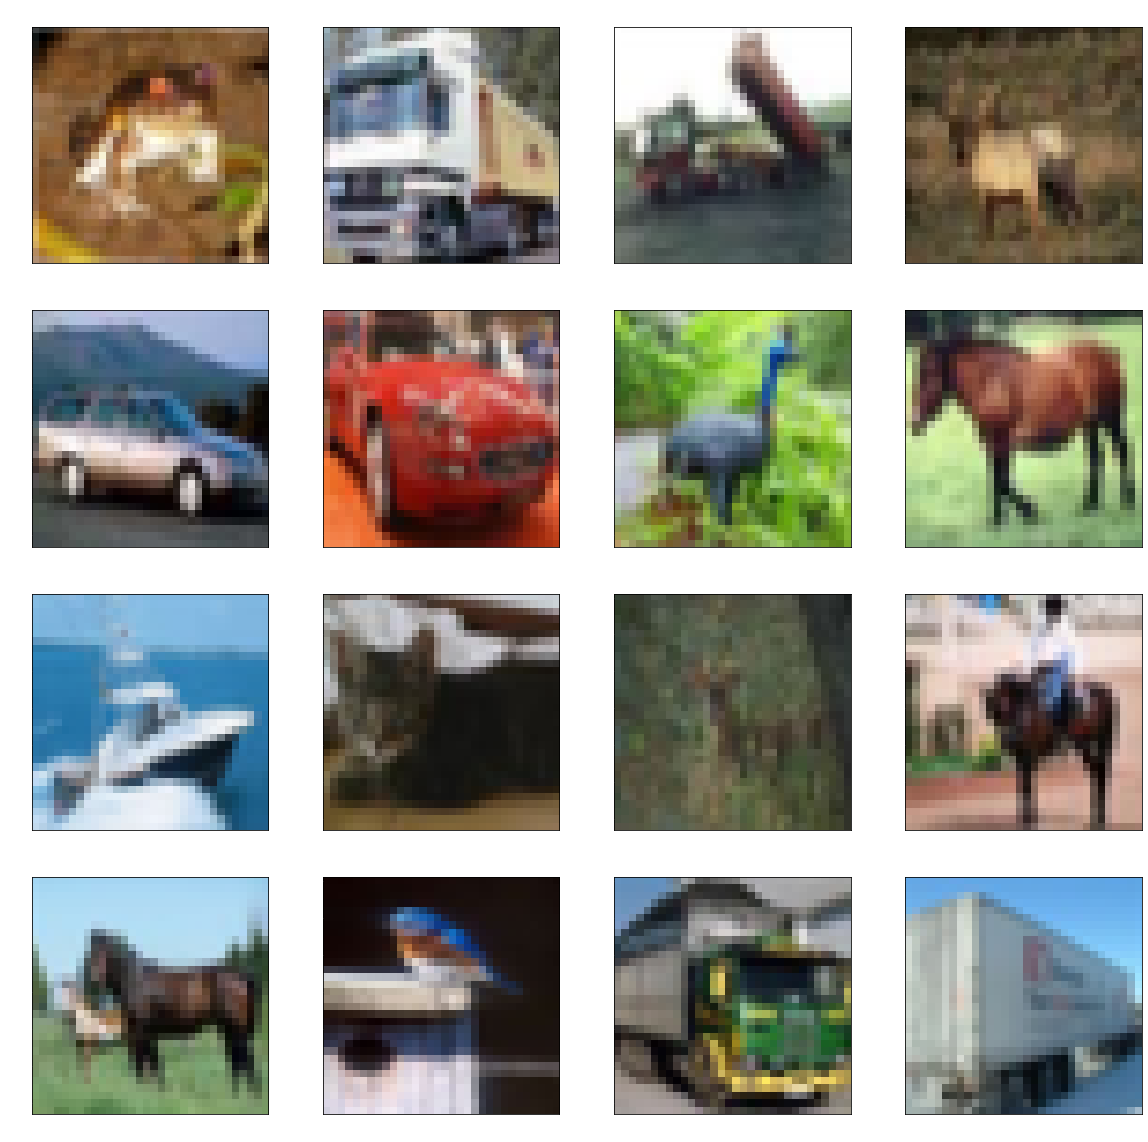

In [6]:
min_transform = torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    ])
dataset = torchvision.datasets.CIFAR10("../data",
                                       transform=min_transform,
                                       download=True)

fig, axs = plt.subplots(4, 4,figsize=(20,20))
sample = np.random.randint(0,len(dataset),64)
for i in range(16):
    img, target = dataset.__getitem__(i)
    img = img.permute(1,2,0)
    axs[i//4,i%4].imshow(img)
    axs[i//4,i%4].set_title("{} min: {:.2f} max: {:.2f}".format(dataset.classes[target],torch.min(img),torch.max(img)))

In [7]:
batch_size =  64

split = (0.4, 0.3, 0.3)

training_samples = int(len(dataset) * split[0])
validation_samples = int(len(dataset) *  split[1])
test_samples = len(dataset) - training_samples - validation_samples

train_ds, valid_ds, test_ds = torch.utils.data.random_split(dataset, (training_samples, validation_samples, test_samples))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [8]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)

        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)

        self.pool = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout(p=0.0, inplace=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #batch_size x 64 x 15 x 15
        x = self.dropout1(x)
        #batch_size x 64 x 15 x 15
        x = self.pool(F.relu(self.conv2(x)))
        #batch_size x 64 x 6 x 6
        x = self.dropout1(x)
        #batch_size x 64 x 6 x 6
        x = self.pool(F.relu(self.conv3(x)))
        #batch_size x 128 x 2 x 2
        x = self.dropout1(x)
        x = x.view(-1, 128 * 2 * 2)
        #batch_size x 1 x 512

        x = F.relu(self.fc1(x))
        #batch_size x 1 x 128

        x = F.relu(self.fc2(x))
        #batch_size x 1 x 64

        x = F.relu(self.fc3(x))
        #batch_size x 1 x 32

        x = self.fc4(x)
        #batch_size x 1 x 10

        return x


In [9]:
def visualize_batch_loss(batch_train_losses):
    plt.figure(figsize=(15,3))
    xx = np.arange(0,len(batch_train_losses),1)
    y_train =  np.array(batch_train_losses)
    plt.plot(xx, y_train)
    plt.legend(["Training Loss"],labelcolor='black')
    plt.xlabel("Batches")
    plt.ylabel("Loss")
    plt.title("Loss of validation and training set")
    plt.show()

def visualize_loss(avg_valid_losses,avg_train_losses):
    plt.figure()
    xx = np.arange(0,len(avg_valid_losses),1)
    y_valid = np.array(avg_valid_losses)
    y_train =  np.array(avg_train_losses)
    plt.plot(xx, y_valid)
    plt.plot(xx, y_train,color='red')
    plt.legend(("Validation Loss","Training Loss"),labelcolor='black')
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.title("Loss of validation and training set")
    plt.show()

In [10]:
def train(model, n_epochs,train_loader,valid_loader,criterion,optimizer,scheduler=None,early_stop_count=0):
    avg_train_losses = []
    avg_valid_losses = []
    avg_valid_acc = []
    batch_train_losses= []

    early_stopping = EarlyStopping(patience=early_stop_count, verbose=True, path="net.pth")

    for epoch in range(1, n_epochs + 1):
        train_losses = []
        valid_losses = []
        valid_accs = []

        model.train() # prep model for training
        for input_data, classes in train_loader:
            data = input_data.to(device)
            target = classes.long().to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        for input_data, classes in valid_loader:
            data = input_data.to(device)
            target = classes.long().to(device)

            output = model(data)
            loss = criterion(output, target)
            valid_losses.append(loss.item())

            _, pred = torch.max(output, 1)

            valid_accs.append(np.sum(target.cpu().numpy() == pred.cpu().numpy()) / pred.shape[0])



        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        valid_acc = np.average(valid_accs)

        if scheduler:
            scheduler.step()

        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_valid_acc.append(valid_acc)
        batch_train_losses.extend(train_losses)

        epoch_len = len(str(n_epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} '
                     f'valid_acc: {valid_acc*100:2.2f} %')
        if scheduler:
            print_msg = print_msg + " lr: {:.5f}".format(scheduler.get_last_lr()[0])
        print(print_msg)

        if early_stop_count:
            early_stopping(valid_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break
    if early_stop_count:
        model.load_state_dict(torch.load("net.pth"))

    return avg_valid_losses, avg_train_losses, model, batch_train_losses

In [11]:
def print_accuracy(model, criterion, test_loader):
    y_gts = np.array([])
    y_preds = np.array([])
    for input_data, classes in test_loader:
        x = input_data.to(device)
        y = classes.long().to(device)
        output = model(x)
        _, pred = torch.max(output, 1)

        y_gts = np.hstack((y_gts, y.cpu().numpy()))
        y_preds = np.hstack((y_preds, pred.cpu().numpy()))

    print("Accuracy the NN is : {:2.2f} %".format(np.sum(y_gts==y_preds)/y_preds.shape[0]*100))

## Experiments
### 1. Optimizer choice, Learning Rate tuning.
* Lets set learning rate with Stochastic gradient descent to 0.5
* This results in oscillation around local minimum
* https://cs231n.github.io/neural-networks-3/

[ 1/20] train_loss: 2.30068 valid_loss: 2.30371 valid_acc: 9.91 %
[ 2/20] train_loss: 2.30232 valid_loss: 2.30428 valid_acc: 10.11 %
[ 3/20] train_loss: 2.30434 valid_loss: 2.30601 valid_acc: 9.66 %
[ 4/20] train_loss: 2.30459 valid_loss: 2.30509 valid_acc: 10.12 %
[ 5/20] train_loss: 2.30410 valid_loss: 2.30414 valid_acc: 9.96 %
[ 6/20] train_loss: 2.30445 valid_loss: 2.30403 valid_acc: 9.65 %
[ 7/20] train_loss: 2.30445 valid_loss: 2.30382 valid_acc: 10.08 %
[ 8/20] train_loss: 2.30436 valid_loss: 2.30491 valid_acc: 9.96 %
[ 9/20] train_loss: 2.30460 valid_loss: 2.30546 valid_acc: 10.08 %
[10/20] train_loss: 2.30466 valid_loss: 2.30586 valid_acc: 9.96 %
[11/20] train_loss: 2.30456 valid_loss: 2.30542 valid_acc: 9.95 %
[12/20] train_loss: 2.30436 valid_loss: 2.30600 valid_acc: 9.66 %
[13/20] train_loss: 2.30434 valid_loss: 2.30719 valid_acc: 9.96 %
[14/20] train_loss: 2.30435 valid_loss: 2.30808 valid_acc: 9.96 %
[15/20] train_loss: 2.30459 valid_loss: 2.30398 valid_acc: 9.91 %
[16/20

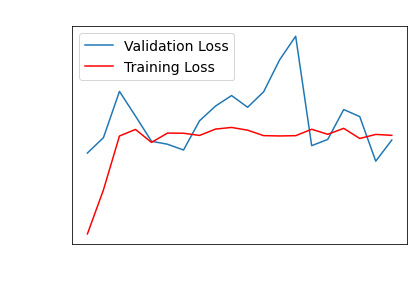

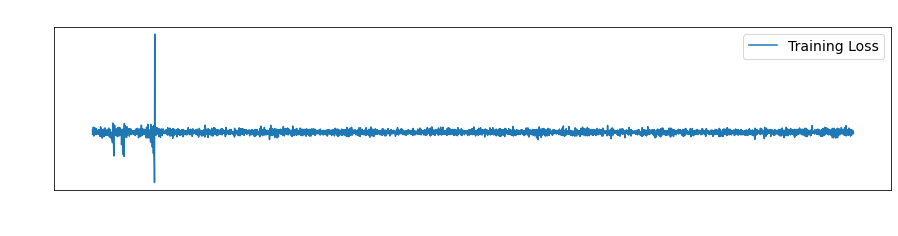

Accuracy the NN is : 10.20 %


In [12]:
model = Net().to(device)
criterion_CE = nn.CrossEntropyLoss()

optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.5)
avg_valid_losses, avg_train_losses, model,batch_train_losses = train(model,20,train_loader,valid_loader,
                                                                     criterion=criterion_CE,
                                                                     optimizer=optimizer_SGD)
visualize_loss(avg_valid_losses,avg_train_losses)
visualize_batch_loss(batch_train_losses=batch_train_losses)
print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

#### 1. Low learning rate
* decrease the learning
* results in very slow learning
* we can either add learning rate scheduler that will decrease the learning the rate  or use different optimizer
* results in vanishing gradient issue

[ 1/20] train_loss: 2.30892 valid_loss: 2.30770 valid_acc: 10.11 %
[ 2/20] train_loss: 2.30834 valid_loss: 2.30724 valid_acc: 10.11 %
[ 3/20] train_loss: 2.30789 valid_loss: 2.30682 valid_acc: 10.11 %
[ 4/20] train_loss: 2.30747 valid_loss: 2.30644 valid_acc: 10.11 %
[ 5/20] train_loss: 2.30704 valid_loss: 2.30609 valid_acc: 10.11 %
[ 6/20] train_loss: 2.30658 valid_loss: 2.30577 valid_acc: 10.11 %
[ 7/20] train_loss: 2.30629 valid_loss: 2.30548 valid_acc: 10.11 %
[ 8/20] train_loss: 2.30600 valid_loss: 2.30522 valid_acc: 10.11 %
[ 9/20] train_loss: 2.30563 valid_loss: 2.30498 valid_acc: 10.11 %
[10/20] train_loss: 2.30535 valid_loss: 2.30476 valid_acc: 10.11 %
[11/20] train_loss: 2.30509 valid_loss: 2.30457 valid_acc: 10.11 %
[12/20] train_loss: 2.30490 valid_loss: 2.30439 valid_acc: 10.11 %
[13/20] train_loss: 2.30471 valid_loss: 2.30422 valid_acc: 10.11 %
[14/20] train_loss: 2.30449 valid_loss: 2.30407 valid_acc: 10.11 %
[15/20] train_loss: 2.30430 valid_loss: 2.30394 valid_acc: 10.

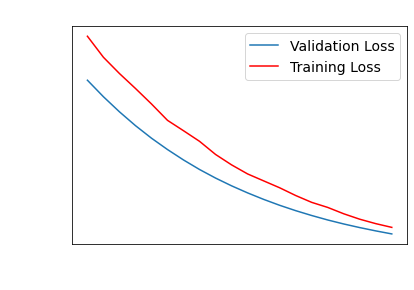

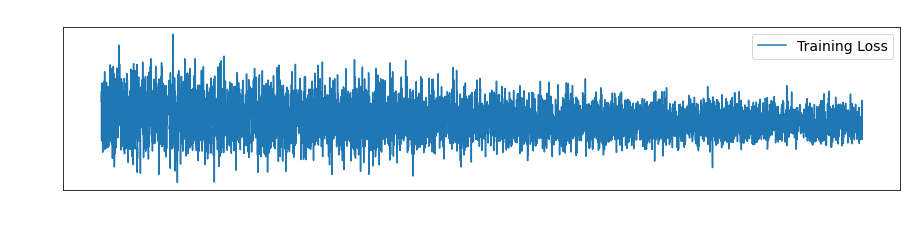

Accuracy the NN is : 9.89 %


In [13]:
model = Net().to(device)
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.001)
avg_valid_losses, avg_train_losses, model,batch_train_losses = train(model,20,train_loader,valid_loader,
                                                                     criterion=criterion_CE,
                                                                     optimizer=optimizer_SGD)
visualize_loss(avg_valid_losses,avg_train_losses)
visualize_batch_loss(batch_train_losses=batch_train_losses)

print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

[ 1/20] train_loss: 2.30345 valid_loss: 2.30174 valid_acc: 9.65 % lr: 0.10000
[ 2/20] train_loss: 2.28861 valid_loss: 2.19513 valid_acc: 18.54 % lr: 0.10000
[ 3/20] train_loss: 2.14746 valid_loss: 2.06689 valid_acc: 21.58 % lr: 0.10000
[ 4/20] train_loss: 2.01542 valid_loss: 2.05072 valid_acc: 24.91 % lr: 0.10000
[ 5/20] train_loss: 1.86750 valid_loss: 1.79682 valid_acc: 32.97 % lr: 0.07500
[ 6/20] train_loss: 1.72303 valid_loss: 1.74512 valid_acc: 34.05 % lr: 0.07500
[ 7/20] train_loss: 1.65073 valid_loss: 1.83050 valid_acc: 34.37 % lr: 0.07500
[ 8/20] train_loss: 1.56683 valid_loss: 1.63759 valid_acc: 40.69 % lr: 0.07500
[ 9/20] train_loss: 1.47370 valid_loss: 1.50739 valid_acc: 44.54 % lr: 0.07500
[10/20] train_loss: 1.39258 valid_loss: 1.63797 valid_acc: 41.34 % lr: 0.05625
[11/20] train_loss: 1.26730 valid_loss: 1.38818 valid_acc: 49.30 % lr: 0.05625
[12/20] train_loss: 1.20810 valid_loss: 1.42087 valid_acc: 48.45 % lr: 0.05625
[13/20] train_loss: 1.14865 valid_loss: 1.26500 valid

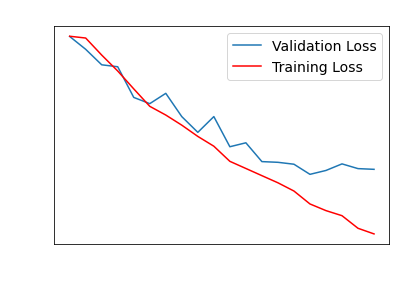

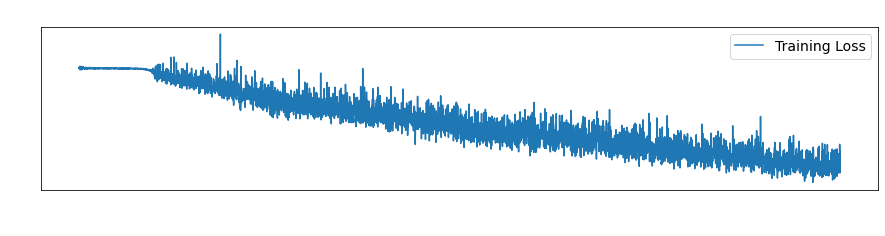

Accuracy the NN is : 61.18 %


In [14]:
model = Net().to(device)

optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_SGD,[5,10,15, 18],0.75)
avg_valid_losses, avg_train_losses, model, batch_train_losses = train(model,20,train_loader,valid_loader,
                                                                     criterion=criterion_CE,
                                                                     optimizer=optimizer_SGD,
                                                                      scheduler=scheduler)
visualize_loss(avg_valid_losses,avg_train_losses)
visualize_batch_loss(batch_train_losses=batch_train_losses)

print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

## Great content on the topic
* https://ruder.io/optimizing-gradient-descent/
* Adam is generally good, due to adaptive learning rate for each parameter update
* is another method that computes adaptive learning rates for each parameter.
In addition to storing an exponentially decaying average of past squared gradients like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients , similar to momentum.

[ 1/20] train_loss: 2.01830 valid_loss: 1.76616 valid_acc: 31.77 %
[ 2/20] train_loss: 1.66247 valid_loss: 1.55659 valid_acc: 41.31 %
[ 3/20] train_loss: 1.48738 valid_loss: 1.43927 valid_acc: 46.34 %
[ 4/20] train_loss: 1.36174 valid_loss: 1.38451 valid_acc: 47.76 %
[ 5/20] train_loss: 1.26432 valid_loss: 1.31947 valid_acc: 51.79 %
[ 6/20] train_loss: 1.18456 valid_loss: 1.22784 valid_acc: 56.21 %
[ 7/20] train_loss: 1.10889 valid_loss: 1.20944 valid_acc: 56.47 %
[ 8/20] train_loss: 1.03826 valid_loss: 1.21009 valid_acc: 57.11 %
[ 9/20] train_loss: 0.99090 valid_loss: 1.15755 valid_acc: 59.73 %
[10/20] train_loss: 0.91926 valid_loss: 1.14632 valid_acc: 60.65 %
[11/20] train_loss: 0.86903 valid_loss: 1.09563 valid_acc: 62.07 %
[12/20] train_loss: 0.81599 valid_loss: 1.11720 valid_acc: 61.97 %
[13/20] train_loss: 0.77101 valid_loss: 1.09139 valid_acc: 62.90 %
[14/20] train_loss: 0.71863 valid_loss: 1.12514 valid_acc: 62.45 %
[15/20] train_loss: 0.67942 valid_loss: 1.09382 valid_acc: 64.

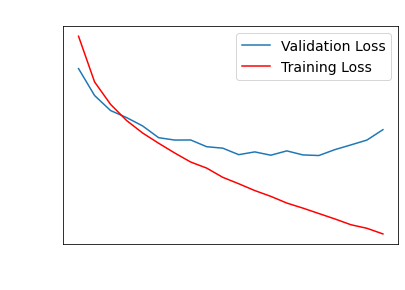

Accuracy the NN is : 64.33 %


In [15]:
model = Net().to(device)

optimizer_SGD = torch.optim.Adam(model.parameters(), lr=0.001)

avg_valid_losses, avg_train_losses, model,_ = train(model,20,train_loader,valid_loader,
                                                  criterion=criterion_CE,
                                                  optimizer=optimizer_SGD,
                                                  scheduler=None)
visualize_loss(avg_valid_losses,avg_train_losses)
print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)


### 2.Dropout
* simple, but works like a charm

[ 1/20] train_loss: 2.03896 valid_loss: 1.82719 valid_acc: 29.19 %
[ 2/20] train_loss: 1.71922 valid_loss: 1.63691 valid_acc: 37.81 %
[ 3/20] train_loss: 1.57835 valid_loss: 1.48244 valid_acc: 44.55 %
[ 4/20] train_loss: 1.46243 valid_loss: 1.44745 valid_acc: 45.45 %
[ 5/20] train_loss: 1.37276 valid_loss: 1.33584 valid_acc: 50.72 %
[ 6/20] train_loss: 1.29567 valid_loss: 1.32939 valid_acc: 51.04 %
[ 7/20] train_loss: 1.24118 valid_loss: 1.26608 valid_acc: 54.37 %
[ 8/20] train_loss: 1.19543 valid_loss: 1.17499 valid_acc: 57.97 %
[ 9/20] train_loss: 1.15320 valid_loss: 1.15647 valid_acc: 58.44 %
[10/20] train_loss: 1.11402 valid_loss: 1.11063 valid_acc: 60.04 %
[11/20] train_loss: 1.06285 valid_loss: 1.08382 valid_acc: 61.31 %
[12/20] train_loss: 1.02678 valid_loss: 1.05760 valid_acc: 62.50 %
[13/20] train_loss: 0.99464 valid_loss: 1.04456 valid_acc: 62.12 %
[14/20] train_loss: 0.96491 valid_loss: 1.08344 valid_acc: 61.14 %
[15/20] train_loss: 0.94167 valid_loss: 1.02017 valid_acc: 63.

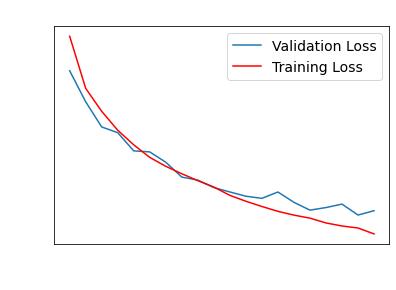

Accuracy the NN is : 66.90 %


In [16]:
model = Net().to(device)

model.maroskova_vrstva = nn.Dropout(0.2)

optimizer_SGD = torch.optim.Adam(model.parameters(), lr=0.001)

avg_valid_losses, avg_train_losses, model,_ = train(model,
                                                  20,
                                                  train_loader,
                                                  valid_loader,
                                                  criterion=criterion_CE,
                                                  optimizer=optimizer_SGD,
                                                  scheduler=None)
visualize_loss(avg_valid_losses,avg_train_losses)
print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

In [17]:
class NetBatchNorm(nn.Module):
    def __init__(self):
        super(NetBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.batch_norm_conv1 = nn.BatchNorm2d(64, affine=False)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.batch_norm_conv2 = nn.BatchNorm2d(64, affine=False)

        self.conv3 = nn.Conv2d(64, 128, 3)
        self.batch_norm_conv3 = nn.BatchNorm2d(128, affine=False)


        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.batch_norm1 = nn.BatchNorm1d(128, affine=False)

        self.fc2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64, affine=False)

        self.fc3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32, affine=False)

        self.fc4 = nn.Linear(32, 10)


        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(p=0.0, inplace=False)

    def forward(self, x):
        x = self.pool(self.batch_norm_conv1(F.relu(self.conv1(x))))
        #batch_size x 64 x 15 x 15
        x = self.dropout1(x)
        #batch_size x 64 x 15 x 15
        x = self.pool(self.batch_norm_conv2(F.relu(self.conv2(x))))
        #batch_size x 64 x 6 x 6
        x = self.dropout1(x)
        #batch_size x 64 x 6 x 6
        x = self.pool(self.batch_norm_conv3(F.relu(self.conv3(x))))
        #batch_size x 128 x 2 x 2
        x = self.dropout1(x)
        x = x.view(-1, 128 * 2 * 2)
        #batch_size x 1 x 512

        x = self.batch_norm1(F.relu(self.fc1(x)))
        #batch_size x 1 x 128

        x = self.batch_norm2(F.relu(self.fc2(x)))
        #batch_size x 1 x 64

        x = self.batch_norm3(F.relu(self.fc3(x)))
        #batch_size x 1 x 32

        x = self.fc4(x)
        #batch_size x 1 x 10

        return x


### 3. Batch normalization
* goal to normalize output based on the statistics of the batch
* original paper recommends  to use batch norm before activation -https://arxiv.org/pdf/1502.03167.pdf
* however the last body of research uses it after activation

[1/5] train_loss: 1.57353 valid_loss: 1.32631 valid_acc: 52.38 %
[2/5] train_loss: 1.17013 valid_loss: 1.25808 valid_acc: 54.45 %
[3/5] train_loss: 0.98124 valid_loss: 1.14949 valid_acc: 59.64 %
[4/5] train_loss: 0.83783 valid_loss: 1.07079 valid_acc: 63.29 %
[5/5] train_loss: 0.73664 valid_loss: 0.99793 valid_acc: 65.59 %


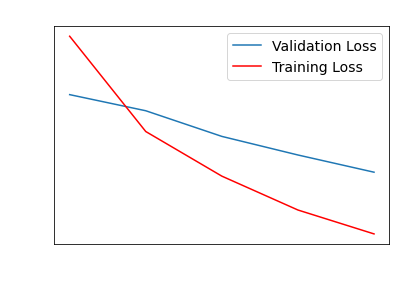

Accuracy the NN is : 66.69 %


In [18]:
model = NetBatchNorm().to(device)
model.dropout1 = nn.Dropout(0.0)
optimizer_SGD = torch.optim.Adam(model.parameters(), lr=0.001)
avg_valid_losses, avg_train_losses, model,_ = train(model,
                                                  5,
                                                  train_loader,
                                                  valid_loader,
                                                  criterion=criterion_CE,
                                                  optimizer=optimizer_SGD,
                                                  scheduler=None)
visualize_loss(avg_valid_losses,avg_train_losses)
print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

### 4. Dataset Augmentation
* https://pytorch.org/vision/stable/transforms.html
1. start conservative, first add noise, flip
2. random erasing
3. affine transform

[ 1/20] train_loss: 2.06171 valid_loss: 1.91961 valid_acc: 24.08 %
[ 2/20] train_loss: 1.82040 valid_loss: 1.76154 valid_acc: 31.10 %
[ 3/20] train_loss: 1.70083 valid_loss: 1.62848 valid_acc: 37.97 %
[ 4/20] train_loss: 1.57909 valid_loss: 1.54245 valid_acc: 41.95 %
[ 5/20] train_loss: 1.47307 valid_loss: 1.46833 valid_acc: 44.44 %
[ 6/20] train_loss: 1.41331 valid_loss: 1.43881 valid_acc: 46.44 %
[ 7/20] train_loss: 1.35409 valid_loss: 1.37426 valid_acc: 49.53 %
[ 8/20] train_loss: 1.29741 valid_loss: 1.34192 valid_acc: 50.26 %
[ 9/20] train_loss: 1.26067 valid_loss: 1.33062 valid_acc: 51.53 %
[10/20] train_loss: 1.21125 valid_loss: 1.29932 valid_acc: 52.76 %
[11/20] train_loss: 1.18850 valid_loss: 1.26401 valid_acc: 54.88 %
[12/20] train_loss: 1.14670 valid_loss: 1.25692 valid_acc: 55.70 %
[13/20] train_loss: 1.12121 valid_loss: 1.16777 valid_acc: 58.35 %
[14/20] train_loss: 1.08079 valid_loss: 1.16047 valid_acc: 58.76 %
[15/20] train_loss: 1.05350 valid_loss: 1.15027 valid_acc: 59.

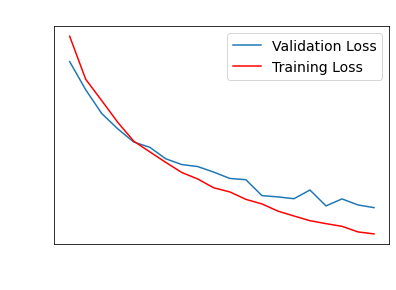

Accuracy the NN is : 61.46 %


In [19]:
aug_transform = torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.RandomVerticalFlip(),
                                    torchvision.transforms.RandomHorizontalFlip(),
                                    ])
dataset.transform = aug_transform

model = Net().to(device)
model.dropout1 = nn.Dropout(0.0)
optimizer_SGD = torch.optim.Adam(model.parameters(), lr=0.001)
avg_valid_losses, avg_train_losses, model,_ = train(model,
                                                  20,
                                                  train_loader,
                                                  valid_loader,
                                                  criterion=criterion_CE,
                                                  optimizer=optimizer_SGD,
                                                  scheduler=None,
                                                  early_stop_count=0)
dataset.transform = min_transform
visualize_loss(avg_valid_losses,avg_train_losses)
print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

### 5. Early stopping

[  1/100] train_loss: 1.67289 valid_loss: 1.41344 valid_acc: 49.20 %
Validation loss decreased (inf --> 1.413437).  Saving model ...
[  2/100] train_loss: 1.29712 valid_loss: 1.18233 valid_acc: 57.42 %
Validation loss decreased (1.413437 --> 1.182332).  Saving model ...
[  3/100] train_loss: 1.14680 valid_loss: 1.13855 valid_acc: 59.46 %
Validation loss decreased (1.182332 --> 1.138554).  Saving model ...
[  4/100] train_loss: 1.04966 valid_loss: 1.04450 valid_acc: 63.22 %
Validation loss decreased (1.138554 --> 1.044500).  Saving model ...
[  5/100] train_loss: 0.96798 valid_loss: 1.05508 valid_acc: 62.85 %
EarlyStopping counter: 1 out of 10
[  6/100] train_loss: 0.90822 valid_loss: 0.96408 valid_acc: 66.28 %
Validation loss decreased (1.044500 --> 0.964082).  Saving model ...
[  7/100] train_loss: 0.85828 valid_loss: 0.97062 valid_acc: 65.62 %
EarlyStopping counter: 1 out of 10
[  8/100] train_loss: 0.82116 valid_loss: 0.90367 valid_acc: 68.42 %
Validation loss decreased (0.964082 --

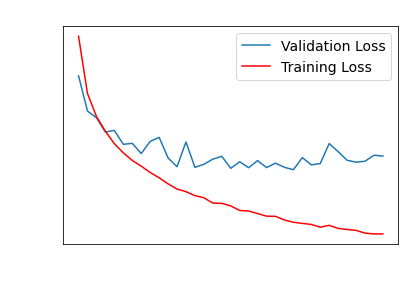

Accuracy the NN is : 74.25 %


In [20]:
model = NetBatchNorm().to(device)
model.dropout1 = nn.Dropout(0.2)
optimizer_SGD = torch.optim.AdamW(model.parameters(), lr=0.001)
avg_valid_losses, avg_train_losses, model,_ = train(model,
                                                  100,
                                                  train_loader,
                                                  valid_loader,
                                                  criterion=criterion_CE,
                                                  optimizer=optimizer_SGD,
                                                  scheduler=None,
                                                  early_stop_count=10)
visualize_loss(avg_valid_losses,avg_train_losses)
dataset.transform = min_transform
print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

# Pokuste sa vytvorit model, a natrenujte model  na CIFAR  s dropoutom a batch normalizaciou na jednotlivych vrstvach.